In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys
from collections import OrderedDict
import numpy as np

import matplotlib.pyplot as plt

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


float32 (500, 256, 256, 1)
float32 (1, 1, 256, 256) float32 (1, 1, 256, 256)


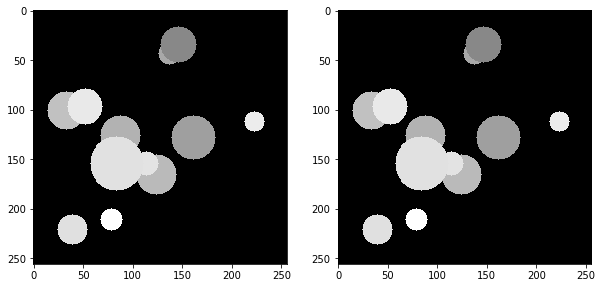

In [2]:
imwidth = 256
imheight = 256
numimgs = 500

dataset=[trainutils.createTestImage(imwidth,imheight,noiseMax=0.0) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]

print(imgin.dtype,imgin.shape)
src=datasource.DataSource(imgin,imgin,augments=[pytorchutils.convertBoth])

with src.threadBatchGen(1) as gen:
    im,im1=gen()
    
print(im.dtype,im.shape,im1.dtype,im1.shape)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(im[0,0])
ax[1].imshow(im1[0,0])

In [3]:
class AEMgrNB(pytorchutils.AutoEncoderMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.AutoEncoderMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,_=self.traininputs
            recons=self.netoutputs[0]

            image=self.toNumpy(images[0,0])
            recon=self.toNumpy(recons[0,0].sigmoid())
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Recon',recon),
                ('Diff',np.abs(image-recon)),
            ])
            
            self.updateImageVals(imgmap)
        

trainSteps=2500
batchSize=20
channels=(8, 16, 32)
strides=(1,  2,  2)
resunits=2
interunits=2
kernelsize=5

net=pytorchnet.AutoEncoder(1,1,channels,strides,kernelsize,numResUnits=resunits,interChannels=[channels[-1]],numInterUnits=interunits)
    
mgr=AEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

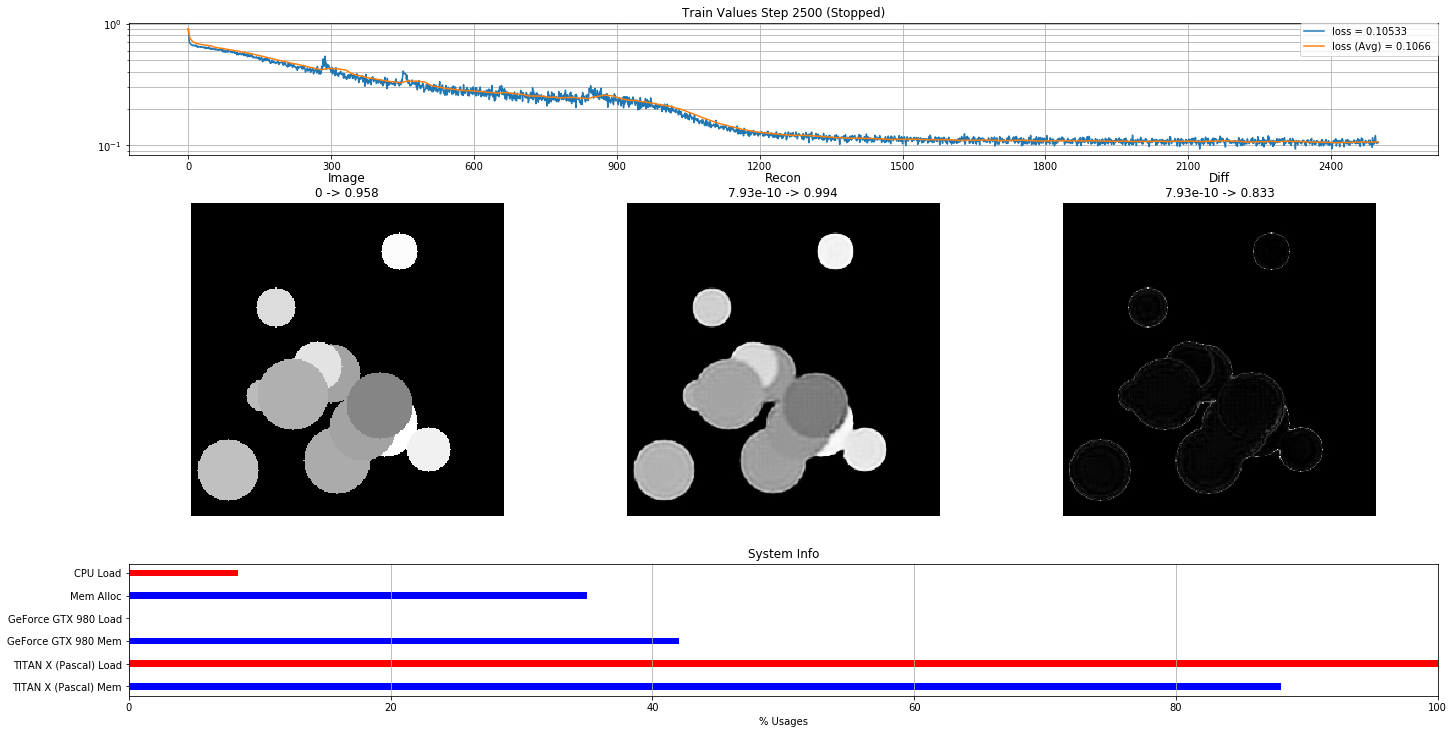

In [4]:
mgr.displayMonitor()

In [5]:
learningRate=1e-4
trainSteps=2500
batchSize=20
channels=(8, 16, 32, 64, 128)
strides=(1,  2,  2,  2,   2)
resunits=1
interunits=1
kernelsize=5

net=pytorchnet.AutoEncoder(1,1,channels,strides,kernelsize,numResUnits=resunits,interChannels=[channels[-1]],numInterUnits=interunits)
    
mgr=AEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

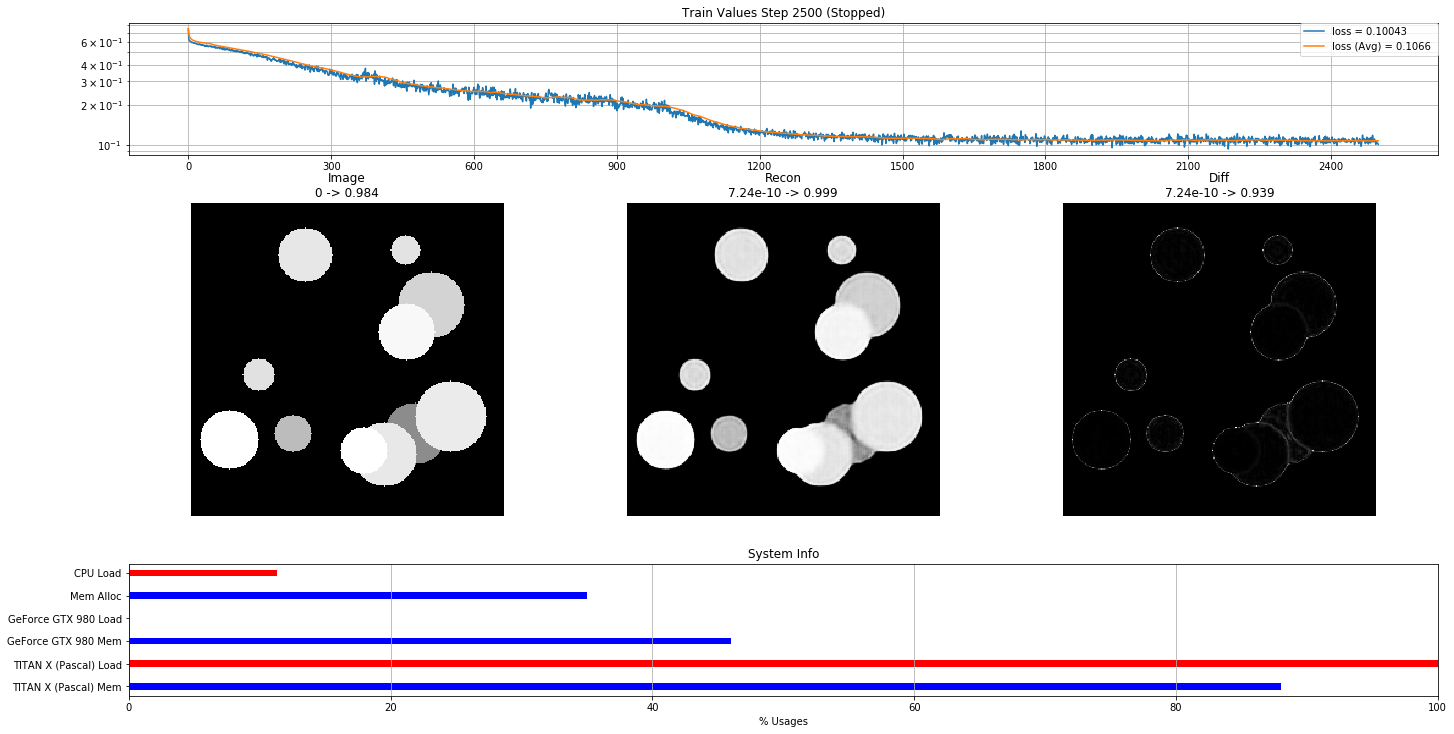

In [6]:
mgr.displayMonitor()